# Download Data

In [ ]:
import requests 
import csv
from multiprocessing.pool import ThreadPool


def _download_image(args):
    session, url, local_path = args[0], args[1], args[2]
    try:
        response = session.get(url)
    except requests.RequestException:
        return False
    if response.status_code != requests.codes.ok:
        return False

    with open(local_path, 'wb') as out:
        out.write(response.content)
    return True

def download_dataset_images(out_dir, dataset_links_tsv='dataset-links.tsv', num_threads=10):
    """Download the dataset images to out_dir, based on the links in dataset_links_tsv.

    dataset_links_tsv is expected to be a tab-separated file with two columns: image url, and local path with format
    <genre>/<album_id>.jpg
    """
#     if os.path.exists(out_dir):
#         raise ValueError('%s already exists' % out_dir)

    session = requests.Session()
    with open(dataset_links_tsv) as fh:
        jobs = []
        genres = set()
        for url, rel_path in csv.reader(fh, delimiter='\t'):
            genres.add(os.path.dirname(rel_path))
            path = os.path.join(out_dir, rel_path)
            if not os.path.exists(path):
                jobs.append((session, url, os.path.join(out_dir, rel_path)))

    for genre in genres:
        genre_path = os.path.join(out_dir, genre)
        if not os.path.exists(genre_path):
            os.makedirs(genre_path)
            
    print('Still needs to download {} covers'.format(len(jobs)))
    pool = ThreadPool(num_threads)
    num_successes = sum(pool.map(_download_image, jobs))
    print('Successfully downloaded %s/%s images' % (num_successes, len(jobs)))
    
download_dataset_images('./img/')

## Look at albums

punk
hiphop_rap
pop
dubstep
rock
soul
jazz
metal
folk
ambient
<a list of 6 Text yticklabel objects>


/usr/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



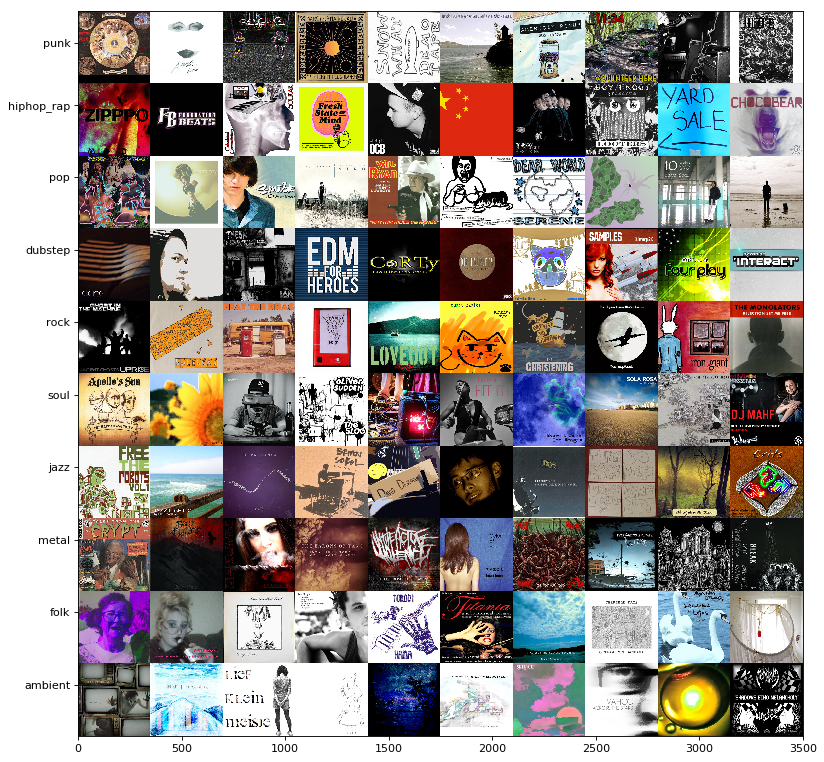

In [60]:
import numpy as np
import matplotlib.pyplot as plt
batch_size = 10
images = []
genres = []
for genre in os.listdir('./img/'):
    print(genre)
    genres.append(genre)
    GENRE_LOCATION = './img/' + genre + '/'
    FOLDER = os.listdir(GENRE_LOCATION)

    images.extend([plt.imread(os.path.abspath(GENRE_LOCATION + f)) for f in FOLDER[0:0+batch_size]])

def gallery(array, ncols=10):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result



result = gallery(np.array(images))
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
print(ax1.get_yticklabels())
ax1.set_yticks([150, 450, 800, 1150, 1500 ,1850, 2200, 2550, 2900, 3250])
ax1.set_yticklabels(genres)
ax1.imshow(result)
fig.show()

# Keras Feature Extraction

### Initialize workspace

In [ ]:
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')
 
#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')
 
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

## Simple version

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
%matplotlib inline
df = pd.DataFrame()

img_model = resnet_model
img_app = resnet50

batch_size = 100
genres = os.listdir('img')
for genre in genres:
    GENRE_LOCATION = './img/' + genre + '/'
    FOLDER = os.listdir(GENRE_LOCATION)
    for i in range(0, 1000, batch_size):
        images = [os.path.abspath(GENRE_LOCATION + f) for f in FOLDER[i:i+batch_size]]
        imgs = []
        for imgf in images:
            img = load_img(imgf, target_size=(224, 224))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = img_app.preprocess_input(x)
            imgs.append(x)
        imgs = np.concatenate(imgs, axis=0)
        print('Created batch of images.. {}: {} - {}'.format(genre, i, i + batch_size))
        img_feats = img_model.predict(imgs)
        preds = pd.DataFrame(np.squeeze(img_feats))
        preds['genre'] = genre
        df = pd.concat([df, preds])

## Adaptive Kernel

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    K.set_session(sess)
    
    import keras_applications
    keras_applications.set_keras_submodules(backend = K)
    
    img_model = keras_applications.resnext.ResNeXt101(weights = 'imagenet', 
        backend = K, layers = keras.layers, models = keras.models, utils = keras.utils)

    df = pd.DataFrame()
    batch_size = 100
    genres = os.listdir('img')
    print(genres)
    for genre in genres:
        GENRE_LOCATION = './img/' + genre + '/'
        FOLDER = os.listdir(GENRE_LOCATION)
        for i in range(0, 1000, batch_size):
            images = [os.path.abspath(GENRE_LOCATION + f) for f in FOLDER[i:i+batch_size]]
            imgs = []
            for imgf in images:
                img = load_img(imgf, target_size=(224,224))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = keras_applications.imagenet_utils.preprocess_input(x, mode='torch')
                imgs.append(x)
            imgs = np.concatenate(imgs, axis=0)
            print('Created batch of images.. {}: {} - {}'.format(genre, i, i + batch_size))
            img_feats = img_model.predict(imgs)
            preds = pd.DataFrame(np.squeeze(img_feats))
            preds['genre'] = genre
            df = pd.concat([df, preds])

## Save the DataFrame

In [ ]:
df.to_csv('output_resnet.csv')

### Look at predictions

In [ ]:
label = decode_predictions(preds)
label

# Caffe2 Feature Extraction

## Initialize Workspace

In [ ]:
from caffe2.python import models
models = os.path.dirname(models.__file__)
MODEL = 'bvlc_googlenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227
IMAGE_LOCATION = "img/ambient/a4072966.jpg"
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"

MEAN_FILE = os.path.join(models, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    print("No mean file found!")
    mean = 128
else:
    print ("Mean file found!")
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print("mean was set to: ", mean)

INIT_NET = os.path.join(models, MODEL[0], MODEL[1])
PREDICT_NET = os.path.join(models, MODEL[0], MODEL[2])
print('Init net file: ', INIT_NET)
print('Predict net file: ', PREDICT_NET)

# Read predictor required init, predict files
with open(INIT_NET, "rb") as f:
    init_net = f.read()
with open(PREDICT_NET, "rb") as f:
    predict_net = f.read()
    
# Initialize the workspace predictor
p = workspace.Predictor(init_net, predict_net)

# Set the labels in a class array
with open('codes.txt', 'r') as response:
    class_LUT = []
    for line in response:
        code, result = line.partition(":")[::2]
        code = code.strip()
        result = result.replace("'", "")
        if code.isdigit():
            class_LUT.append(result.split(",")[0][1:])
            


## Required Functions

In [ ]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img_location, input_height, input_width):
    img = skimage.data.load(img_location)
    aspect = img.shape[1]/float(img.shape[0])

    if aspect > 1:
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    elif aspect < 1:
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    elif aspect == 1:
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    
    return imgScaled

# Initialize batch array
def create_img_batch(images):
    height, width = 224, 224
    NCHW_batch = np.zeros((len(images),3,height,width))
    # For each of the images in the list, format it and place it in the batch
    for i, curr_img in enumerate(images):
        img = rescale(curr_img, height, width)
        img = crop_center(img, height, width)
        img = img.swapaxes(1, 2).swapaxes(0, 1)
        img = img[(2, 1, 0), :, :]
        img = img * 255 - mean
        NCHW_batch[i] = img
    print ("Batch Shape: ",NCHW_batch.shape)
    return NCHW_batch

#Parsing the results of one image, creating topN predictions
def parse_results(results, topN):
    index = 0
    highest = 0
    arr = np.empty((0,2), dtype=object)
    arr[:,0] = int(10)
    arr[:,1:] = float(10)
    for i, r in enumerate(results):
        # imagenet index begins with 1!
        i=i
        arr = np.append(arr, np.array([[i,r]]), axis=0)
        if (r > highest):
            highest = r
            index = i 
            
    topN = sorted(arr, key=lambda x: x[1], reverse=True)[:topN]
#     print("Raw top {} results: {}".format(N,topN))
    prediction = []
    for i, p in topN:
        pred = (class_LUT[int(i)], round(p * 100, 2))
        prediction.append(pred)
    return prediction

def get_labels_for_images(images):
    """Returns list of labels that were predicted from given images"""
    batch = create_img_batch(images)
    results = p.run([batch.astype(np.float32)])

    # Turn it into a multi-dimensional array
    results = np.asarray(results)
    # Squeeze out the unnecessary axis
    preds = np.squeeze(results)
    print("Squeezed Predictions Shape, with batch size {}: {}".format(len(images),preds.shape))

    labels = []
    for i, pred in enumerate(preds):
        predictions = parse_results(pred, 10)
#         print('Predictions for img: {}:'.format(images[i]))
        for pred in predictions:
#             print(pred)
            labels.append(pred[0])
    return labels

def add_labels_to_genre(labels, genre):
    for word in punk:
        genre[word] = genre.get(word, 0) + 1
    return genre

## Create output data frame

In [ ]:
df = pd.DataFrame()
batch_size = 100
genres = {f:{} for f in os.listdir('img')}
for genre in genres:
    GENRE_LOCATION = './img/' + genre + '/'
    FOLDER = os.listdir(GENRE_LOCATION)
    for i in range(0, 1000, batch_size):
        images = [os.path.abspath(GENRE_LOCATION + f) for f in FOLDER[i:i+batch_size]]
        batch = create_img_batch(images)
        results = p.run([batch.astype(np.float32)])
        # Turn it into a multi-dimensional array
        results = np.asarray(results)
        # Squeeze out the unnecessary axis
        preds = pd.DataFrame(np.squeeze(results))
        preds['genre'] = genre
        df = pd.concat([df, preds])
# # Describe the results
# for i, pred in enumerate(preds):
#     print("Results for: '{}' :{}".format(images[i], pred))
#     # Get the prediction and the confidence by finding the maximum value 
#     #   and index of maximum value in preds array
#     curr_pred, curr_conf = max(enumerate(pred), key=operator.itemgetter(1))
#     print("\tPrediction: ", curr_pred)
#     print("\tClass Name: ", class_LUT[int(curr_pred)])
#     print("\tConfidence: ", curr_conf)